# Learn Feature Pyramid Networks (FPN) architecture from scratch with Pytorch

This is my first model FPN architecture in Pytorch.

The link of the paper is :

https://arxiv.org/pdf/1612.03144.pdf

So we get the following picture of the architecture :



# With Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [2]:
class FPN(nn.Module):
    def __init__(self):
        
        super(FPN, self).__init__()
        
        # image R G B 
        self.bn0 = nn.BatchNorm2d(num_features = 3)
        
        # 3x256x256 -> 16x256x256
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)  
        self.bn1   = nn.BatchNorm2d(num_features = 16)
        
        # 16x256x256  -> 32x256x256
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)  
        self.bn2   = nn.BatchNorm2d(num_features = 32)
        
        # 32x256x256 -> 64x256x256
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)  
        self.bn3   = nn.BatchNorm2d(num_features = 64)
        
        # 64x256x256 -> 32x256x256
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)  
        self.bn4   = nn.BatchNorm2d(num_features = 32)
        
        # 32x256x256 -> 16x256x256
        self.conv5 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1)  
        self.bn5   = nn.BatchNorm2d(num_features = 16)
        
        self.down = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride = 2)
        
        self.conv_smooth1 = nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 3, padding = 1)
        self.conv_smooth2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.conv_smooth3 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1)
        self.conv_smooth4 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding = 1)
        
        self.relu = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        self.convtrans1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.convtrans2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.convtrans3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.convtrans4 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1)
        self.convtrans5 = nn.ConvTranspose2d(in_channels = 16, out_channels = 3,  kernel_size = 3, padding = 1)
        
        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        
        # ====== Bottom Up Layers =====
        x = self.bn0(x)
        
        # ((W=256 - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        # W = 256 because in the summary(model.cuda(), (3, 256, 256))
        # I take a picture of 256 x 256
        x = self.bn1(self.relu(self.conv1(x)))
        
        # ((W=256 - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.bn2(self.relu(self.conv2(x)))
        
        # ((W=256 - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.bn3(self.relu(self.conv3(x)))
        
        # H1 = 256, W1 = 256
        _, _, H1, W1 = x.size()
        #print(x.size())
        #print(H1)
        #print(W1)
        
        # ======= Branch network ======
        # ((W=256 - K=3 + 2*P=1)/ S=2 ) + 1 = 128x128
        x_d1 = self.down(x)
        
        # H2 = 128, W2 = 128
        _, _, H2, W2 = x_d1.size()
        
        # ((W=128 - K=3 + 2*P=1)/ S=2 ) + 1 = 64x64
        x_d2 = self.down(x_d1)
        
        # H3 = 64, W3 = 64
        _, _, H3, W3 = x_d2.size()
        
        # ((W=64 - K=3 + 2*P=1)/ S=2 ) = 32x32
        x_d3 = self.down(x_d2)
        
        # H4 = 32, W4 = 32
        _, _, H4, W4 = x_d3.size()
        
        # ((W=32 - K=3 + 2*P=1)/ S=2 ) = 16x16
        x_d4 = self.down(x_d3)
        
        # H5 = 16, W5 = 16
        _, _, H5, W5 = x_d4.size()
        
        # ((W=16 - K=3 + 2*P=1)/ S=2 ) = 8x8
        x_d5 = self.down(x_d4)
        
        # ======= First Branch =======
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.bn4(self.relu(self.conv4(x)))
        
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.bn5(self.relu(self.conv5(x)))
               
        # ======= Second Branch ========
        
        # ((W=128(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 128
        x_d1 = self.bn4(self.relu(self.conv4(x_d1)))
        
        # ((W=128(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 128 
        x_d1 = self.bn5(self.relu(self.conv5(x_d1)))
       
        # From 128 x_d1 to 256 H1, W1
        x_d1 = self.upsample(x_d1, size=(H1, W1))
        
        # ======= Third Branch ========
        
        # ((W=64(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 64
        x_d2 = self.bn4(self.relu(self.conv4(x_d2)))
        
        # ((W=64(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 64
        x_d2 = self.bn5(self.relu(self.conv5(x_d2)))
        
        # From 64 x_d2 to 128 H2, W2
        x_d2 = self.upsample(x_d2, size = (H2, W2))       
        # From 128 x_d2 to 256 H1, W1
        x_d2 = self.upsample(x_d2, size = (H1, W1))
        
        # ======= Fourth Branch ========
        
        # ((W=32(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 32
        x_d3 = self.bn4(self.relu(self.conv4(x_d3)))
        
        # ((W=32(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 32
        x_d3 = self.bn5(self.relu(self.conv5(x_d3)))
        
        # From 32 x_d3 to 64 H3, W3
        x_d3 = self.upsample(x_d3, size = (H3, W3))
        # From 64 x_d3 to 128 H2, W2
        x_d3 = self.upsample(x_d3, size = (H2, W2))
        # From 128 x_d3 to 256 H1, W1
        x_d3 = self.upsample(x_d3, size = (H1, W1))
        
        # ======= Fifth Branch ========
        
        # ((W=16(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 16
        x_d4 = self.bn4(self.relu(self.conv4(x_d4)))
        
        # ((W=16(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 16
        x_d4 = self.bn5(self.relu(self.conv5(x_d4)))
        
        # From 16 x_d4 to 32 H4, W4
        x_d4 = self.upsample(x_d4, size = (H4, W4))
        # From 32 x_d4 to 64 H3, W3
        x_d4 = self.upsample(x_d4, size = (H3, W3))
        # From 64 x_d4 to 128 H2, W2
        x_d4 = self.upsample(x_d4, size = (H2, W2))
        # From 128 x_d4 to 256 H1, W1
        x_d4 = self.upsample(x_d4, size = (H1, W1))      
           
        # ======= Sixth Branch ========
        
        # ((W=8(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 8
        x_d5 = self.bn4(self.relu(self.conv4(x_d5)))
        
        # ((W=8(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 8
        x_d5 = self.bn5(self.relu(self.conv5(x_d5)))
        
        # From 8 x_d5 to 16 H5, W5
        x_d5 = self.upsample(x_d5, size = (H5, W5))
        # From 16 x_d4 to 32 H4, W4
        x_d5 = self.upsample(x_d5, size = (H4, W4))
        # From 32 x_d4 to 64 H3, W3
        x_d5 = self.upsample(x_d5, size = (H3, W3))
        # From 64 x_d4 to 128 H2, W2
        x_d5 = self.upsample(x_d5, size = (H2, W2))
        # From 128 x_d4 to 256 H1, W1
        x_d5 = self.upsample(x_d5, size = (H1, W1))
        
        # ======= Concat maps ==========
        # https://pytorch.org/docs/master/generated/torch.cat.html
        x = torch.cat((x, x_d1, x_d2, x_d3, x_d4, x_d5), 1)
        #print(x.shape)
        
        # conv_smooth1(x) has in_channels = 80 because .cat of x, x_d1, x_d2, x_d3, x_d4, x_d5
        # is 16 + 16 + 16 + 16 + 16 + 16 = 96 and we have H=256 and W=256
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.conv_smooth1(x)
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.conv_smooth2(x)
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.conv_smooth3(x)
        # ((W=256(because of x) - K=3 + 2*P=1)/ S=1 ) + 1 = 256
        x = self.conv_smooth4(x)

        # ============ Decoder ===========
        
        #http://programmersought.com/article/51241069085/;jsessionid=32824BB07AFE28E382F767D76BFDED59
        # ((out=256 -1) * s=1) - (2*P=1) +  K=3 = 256
        x = self.bn2(self.relu(self.convtrans1(x)))
        
        # ((out=256 (because of x) -1) * s=1) - (2*P=1) +  K=3 = 256
        x = self.bn3(self.relu(self.convtrans2(x)))

        # ((out=256 (because of x) -1) * s=1) - (2*P=1) +  K=3 = 256
        x = self.bn4(self.relu(self.convtrans3(x)))
        
        # ((out=256 (because of x) -1) * s=1) - (2*P=1) +  K=3 = 256
        x = self.bn5(self.relu(self.convtrans4(x)))
        
        # ((out=256 (because of x) -1) * s=1) - (2*P=1) +  K=3 = 256 
        x = self.convtrans5(x)
        x = self.sigmoid(x)

        return x

    def upsample(self, x, size):
        up = nn.Upsample(size = size, mode = "bilinear", align_corners = True)
        return up(x)

In [3]:
from torchsummary import summary

model = FPN()
summary(model.cuda(), input_size = (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 256, 256]               6
            Conv2d-2         [-1, 16, 256, 256]             448
              ReLU-3         [-1, 16, 256, 256]               0
       BatchNorm2d-4         [-1, 16, 256, 256]              32
            Conv2d-5         [-1, 32, 256, 256]           4,640
              ReLU-6         [-1, 32, 256, 256]               0
       BatchNorm2d-7         [-1, 32, 256, 256]              64
            Conv2d-8         [-1, 64, 256, 256]          18,496
              ReLU-9         [-1, 64, 256, 256]               0
      BatchNorm2d-10         [-1, 64, 256, 256]             128
           Conv2d-11         [-1, 64, 128, 128]          36,928
           Conv2d-12           [-1, 64, 64, 64]          36,928
           Conv2d-13           [-1, 64, 32, 32]          36,928
           Conv2d-14           [-1, 64,

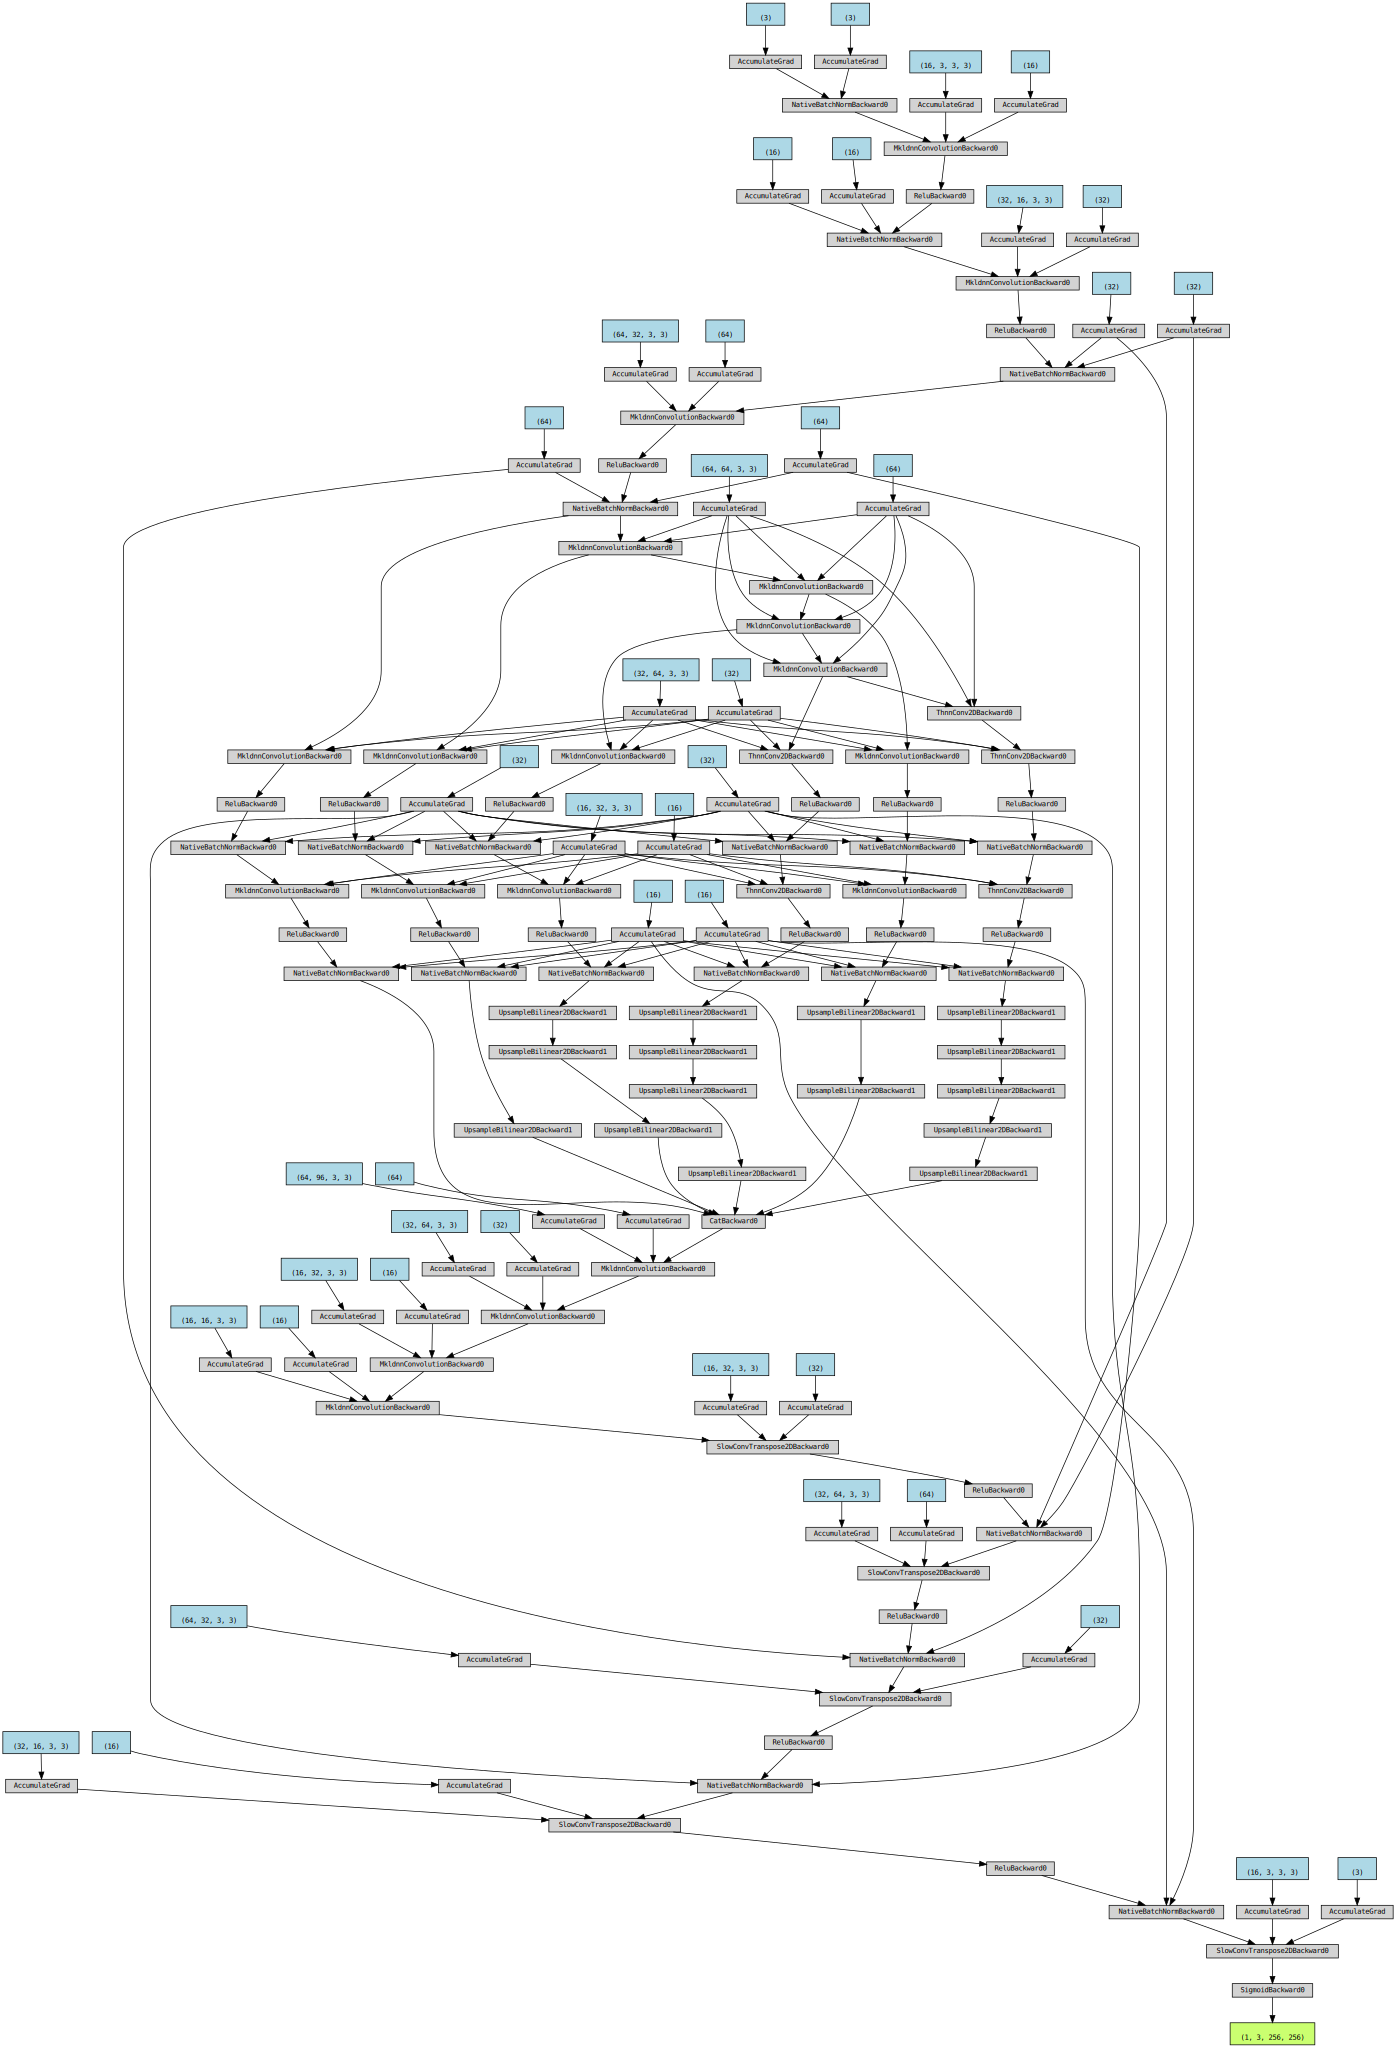

In [4]:
from torchviz import make_dot

x = torch.randn(1, 3, 256, 256)

model_1_cpu = FPN()
model_1_cpu_out = model_1_cpu(x)

#g = make_dot(out, params=None)
#g.view()
make_dot(model_1_cpu_out, params = None)

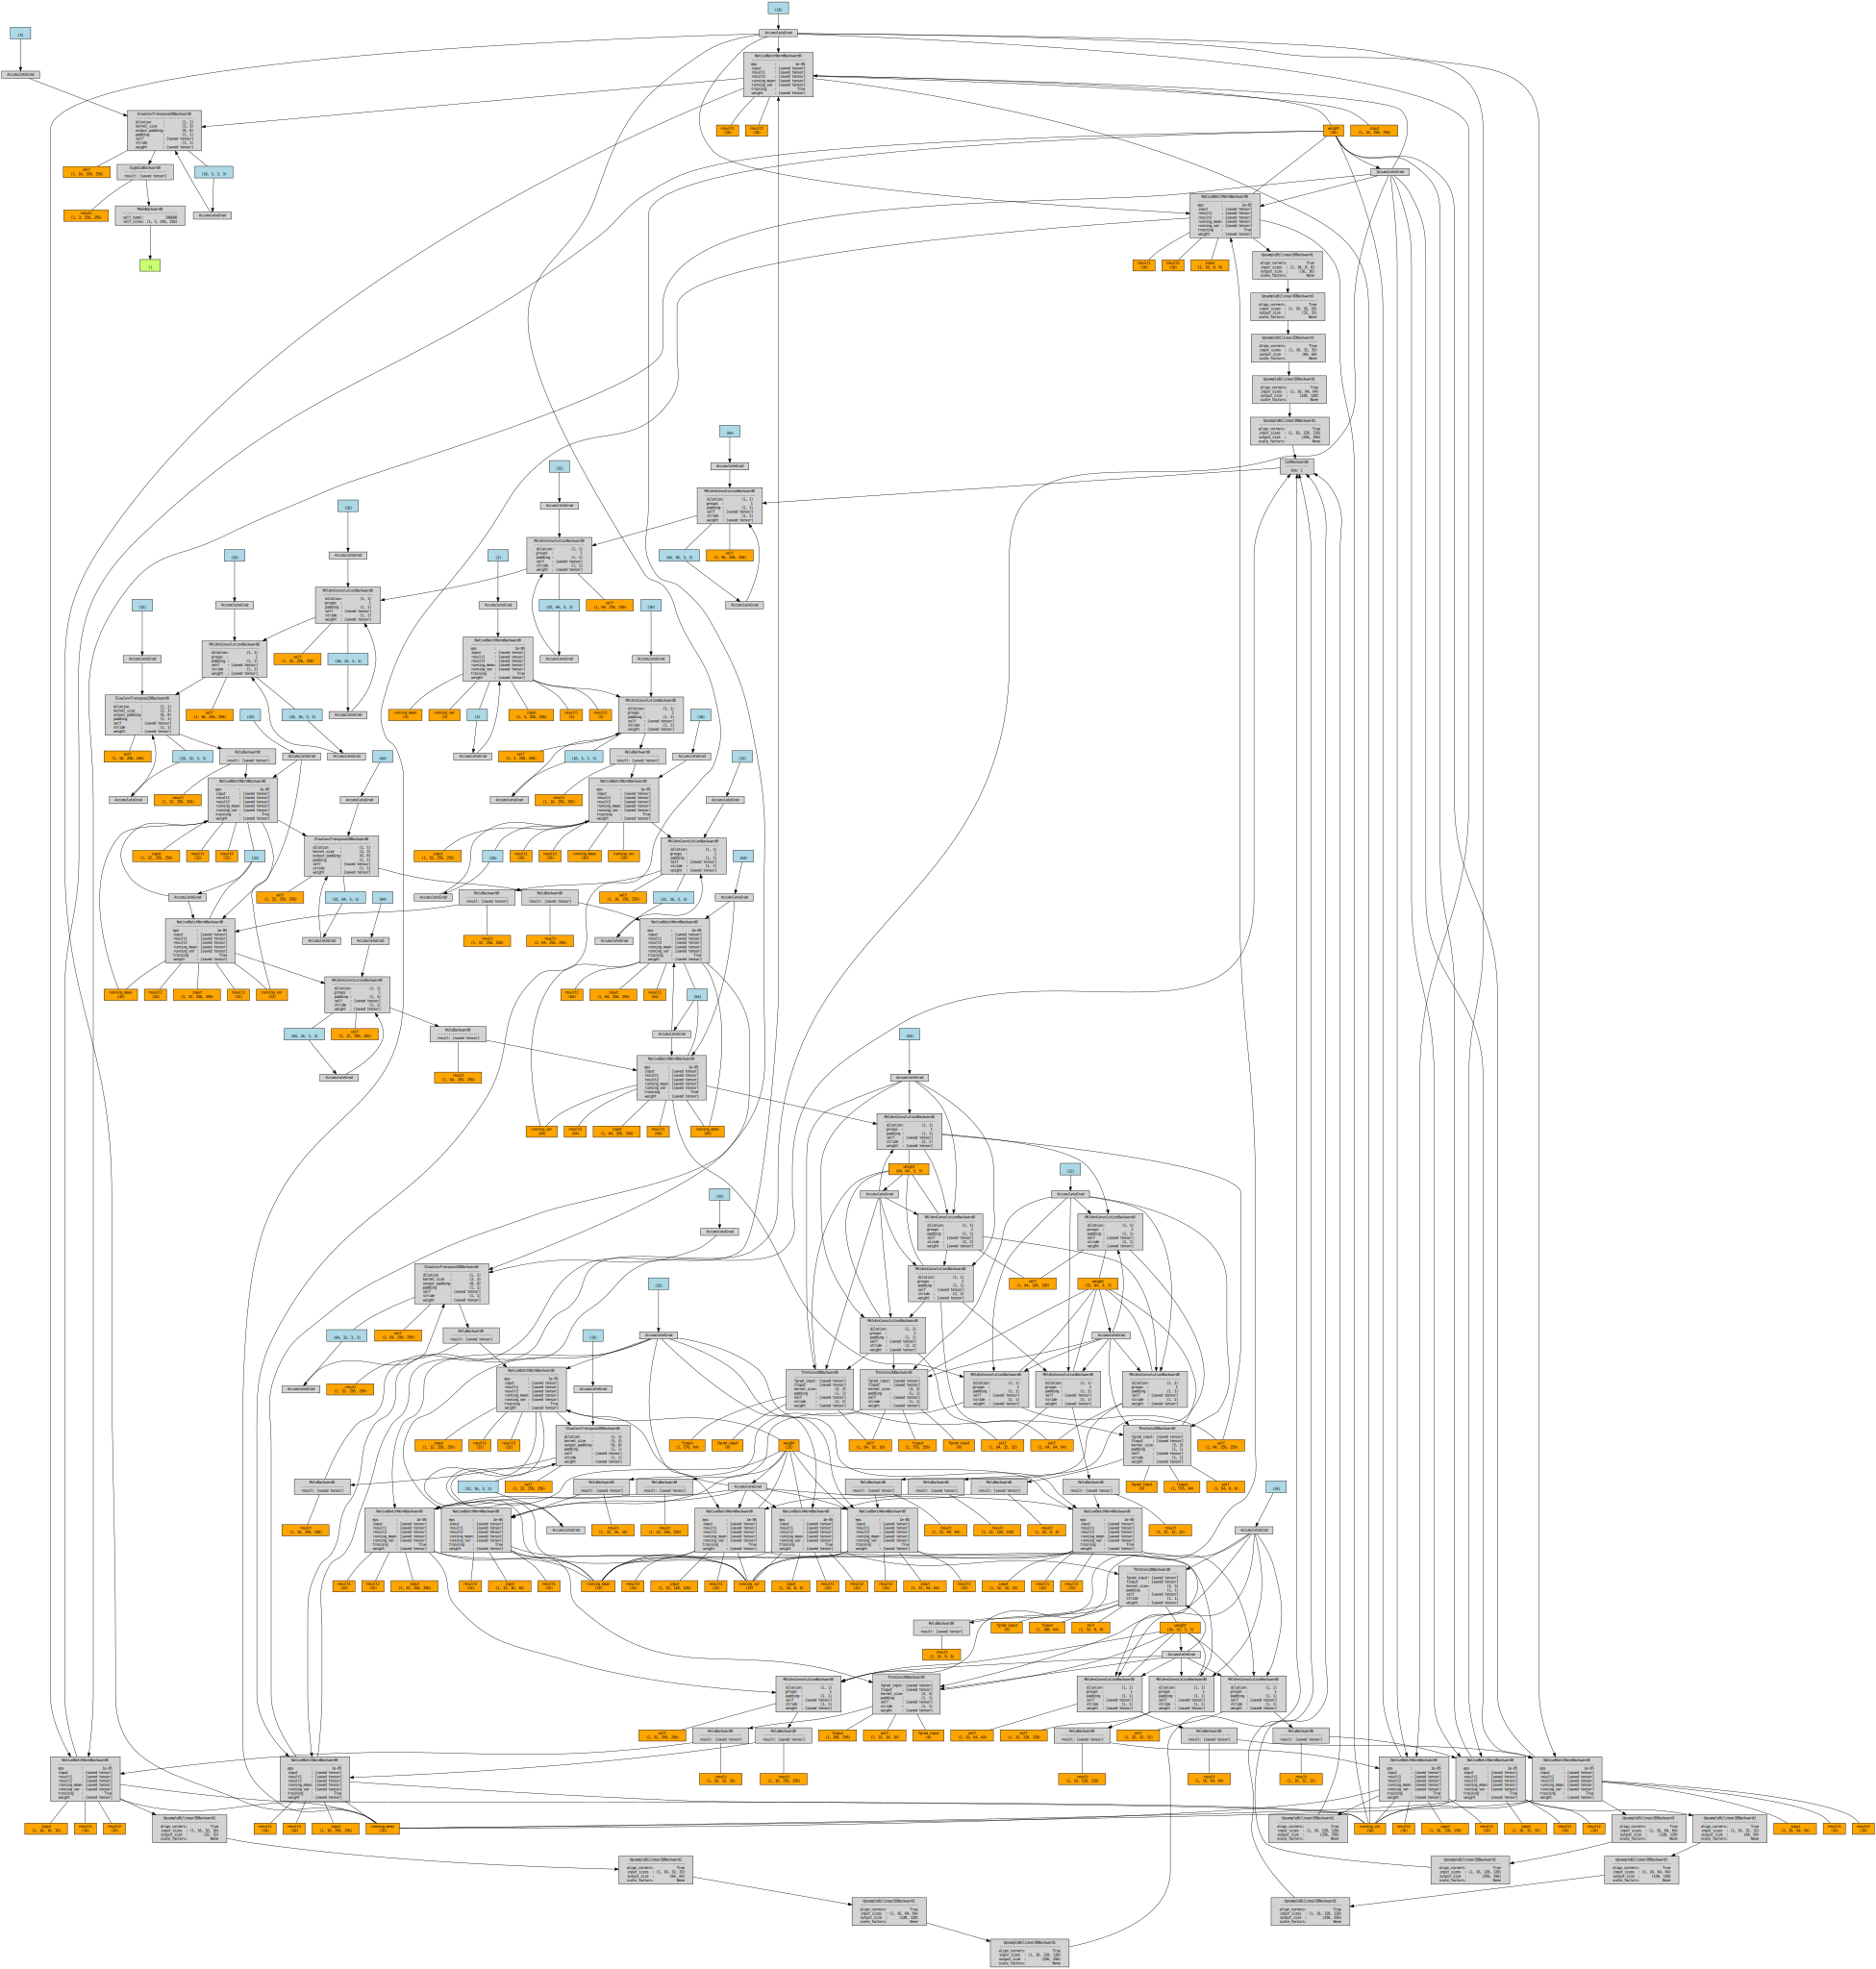

In [5]:
make_dot(model_1_cpu_out.mean(), params = None, show_attrs = True, show_saved = True)